Trying HMC on a mulitmodal gaussian

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

\begin{align}
y & \sim \mathcal{N}(\mu, \sigma^2) \\
\mu & = \alpha + \beta_1 X_1 + \beta_2 X_2 \\
\end{align}


In [3]:
import jax
import jax.numpy as jnp
from jax import lax
from tensorflow_probability.substrates import jax as tfp

import seaborn as sns

In [5]:
# True parameter values
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

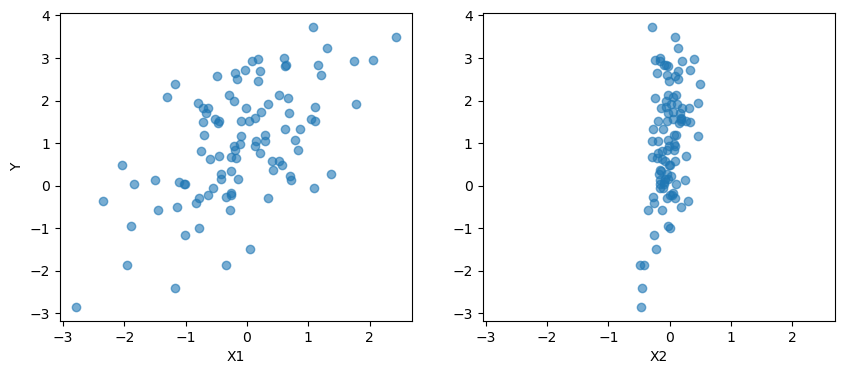

In [7]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2")

In [10]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    trace = pm.sample(2000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.


In [17]:
alphas = jnp.array(trace.posterior["alpha"])#.flatten()
alphas.shape

(4, 2000)

In [27]:
betas = jnp.array(trace.posterior["beta"])#.flatten()
betas.shape

(4, 2000, 2)

In [33]:
sigmas = jnp.array(trace.posterior["sigma"])#.flatten()
sigmas.shape

(4, 2000)

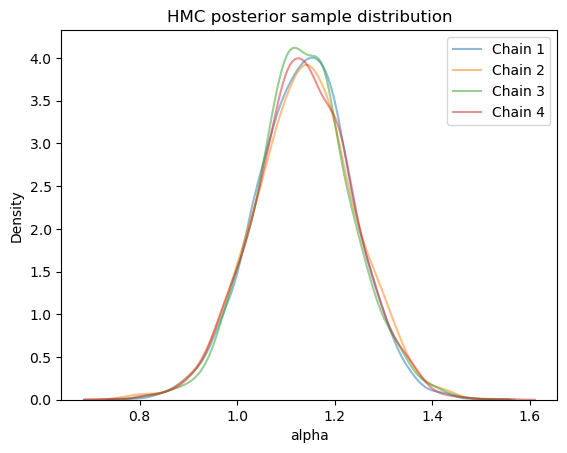

In [16]:
import warnings
warnings.filterwarnings("ignore")

plt.title("HMC posterior sample distribution")
# plt.plot(theta_range, exact_posterior.prob(theta_range), "b--", label="$p(x)$: True Posterior")
for i in range(1, 5):
    sns.kdeplot(alphas[i-1, :], label=f"Chain {i}", alpha = 0.5) #, bw_adjust=1)
plt.xlabel("alpha")
plt.legend()

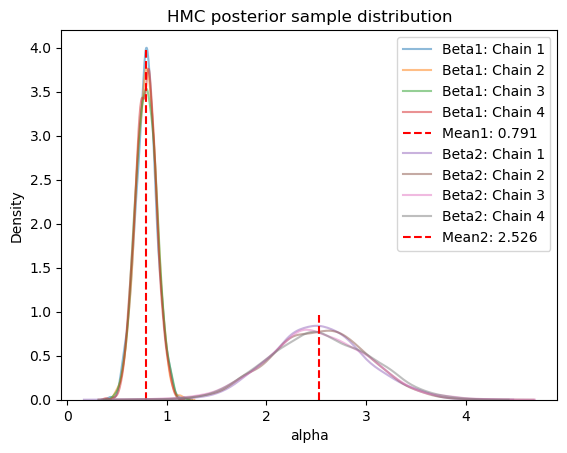

In [32]:
import warnings
warnings.filterwarnings("ignore")

plt.title("HMC posterior sample distribution")
# plt.plot(theta_range, exact_posterior.prob(theta_range), "b--", label="$p(x)$: True Posterior")
for i in range(1, 5):
    sns.kdeplot(betas[i-1, :, 0], label=f"Beta1: Chain {i}", alpha = 0.5) #, bw_adjust=1)

plt.vlines(x=np.mean(betas[:,:,0]), ymin=0, ymax=4, color="red", linestyle="--", label = f"Mean1: {np.mean(betas[:,:,0]):.3f}")
for i in range(1, 5):
    sns.kdeplot(betas[i-1, :, 1], label=f"Beta2: Chain {i}", alpha = 0.5) #, bw_adjust=1)
plt.vlines(x=np.mean(betas[:,:,1]), ymin=0, ymax=1, color="red", linestyle="--", label = f"Mean2: {np.mean(betas[:,:,1]):.3f}")
plt.xlabel("alpha")
plt.legend()

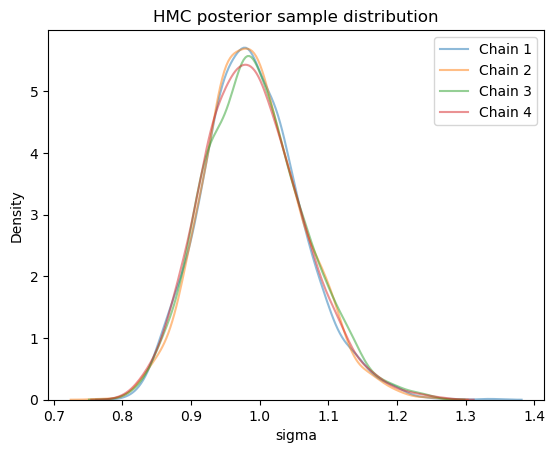

In [34]:
import warnings
warnings.filterwarnings("ignore")

plt.title("HMC posterior sample distribution")
# plt.plot(theta_range, exact_posterior.prob(theta_range), "b--", label="$p(x)$: True Posterior")
for i in range(1, 5):
    sns.kdeplot(sigmas[i-1, :], label=f"Chain {i}", alpha = 0.5) #, bw_adjust=1)
plt.xlabel("sigma")
plt.legend()

Replicating using ADVI method

In [38]:
import time

start_time_advi = time.time()
with pm.Model() as advi_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    # trace = pm.sample(2000, tune=1000, cores=4)

    # Creating an ADVI instance
    advi = pm.ADVI()

    # Tracks the mean and std during training
    tracker = pm.callbacks.Tracker(
        mean=advi.approx.mean.eval,  
        std=advi.approx.std.eval,  
    )

    # Performing the ADVI optimization
    # Here approx is an instance of Approximation class, n is the number of iterations
    approx = advi.fit(callbacks=[tracker], n=20000)

# Draw samples from the approximated posterior
trace_approx = approx.sample(2000)

end_time_advi = time.time()


Finished [100%]: Average Loss = 153.64


In [39]:
print(f"Time taken to execute the cell: {end_time_advi - start_time_advi} seconds")

Time taken to execute the cell: 2.609684944152832 seconds


In [37]:
trace_approx

Inference data with groups:
	> posterior
	> observed_data

In [40]:
alphas = jnp.array(trace_approx.posterior["alpha"]).flatten()
alphas.shape

(2000,)

In [45]:
betas = jnp.array(trace_approx.posterior["beta"])
betas.shape

(1, 2000, 2)

In [47]:
sigmas = jnp.array(trace_approx.posterior["sigma"]).flatten()
sigmas.shape

(2000,)

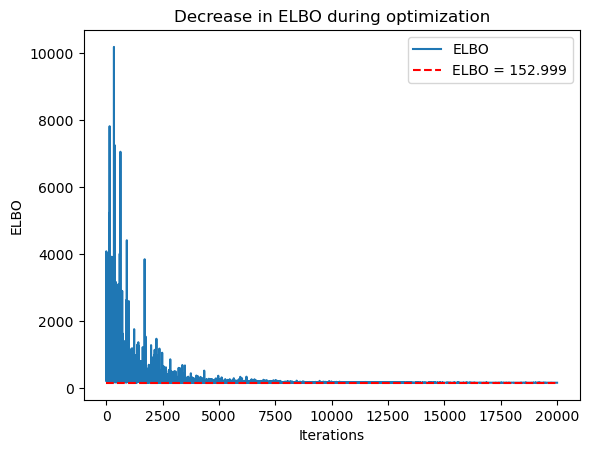

In [41]:
plt.plot(advi.hist, label="ELBO")
plt.title("Decrease in ELBO during optimization")

plt.hlines(y=advi.hist[-1], xmin=0, xmax=len(advi.hist), color = "r", linestyles= "--", 
           label=f"ELBO = {advi.hist[-1]:.3f}")
plt.xlabel("Iterations")
plt.ylabel("ELBO")
plt.legend()
# plt.savefig("advi_beta_binom_pymc_loss.pdf")
plt.show()

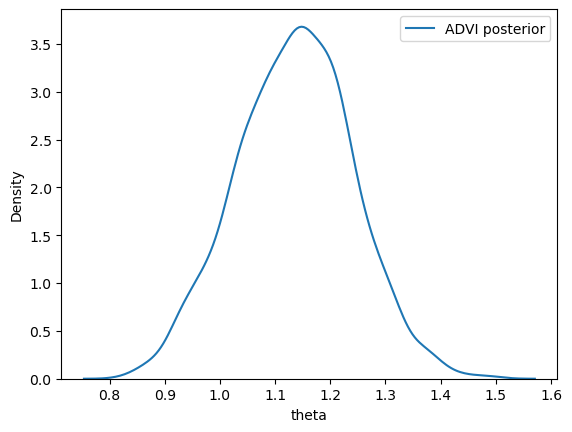

In [43]:
import warnings
warnings.filterwarnings("ignore")

# plt.plot(theta_range, exact_posterior.prob(theta_range), "b--", label="$p(x)$: True Posterior")
sns.kdeplot(alphas, label="ADVI posterior") #, bw_adjust=1)
plt.xlabel("theta")
plt.legend()

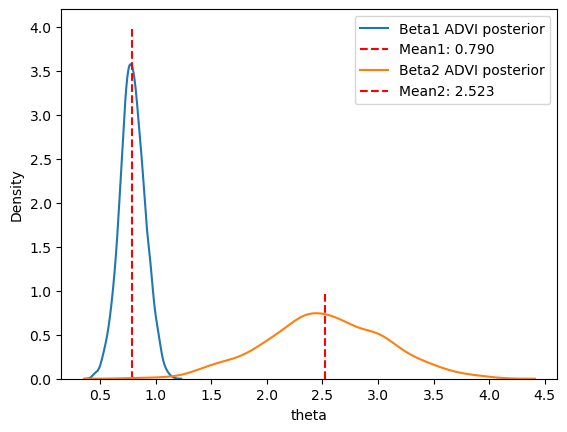

In [46]:
import warnings
warnings.filterwarnings("ignore")

# plt.plot(theta_range, exact_posterior.prob(theta_range), "b--", label="$p(x)$: True Posterior")
sns.kdeplot(betas[0,:, 0], label="Beta1 ADVI posterior") #, bw_adjust=1)
plt.vlines(x=np.mean(betas[0,:,0]), ymin=0, ymax=4, color="red", linestyle="--", label = f"Mean1: {np.mean(betas[0,:,0]):.3f}")
sns.kdeplot(betas[0,:, 1], label="Beta2 ADVI posterior") #, bw_adjust=1)
plt.vlines(x=np.mean(betas[0,:,1]), ymin=0, ymax=1, color="red", linestyle="--", label = f"Mean2: {np.mean(betas[0,:,1]):.3f}")
plt.xlabel("theta")
plt.legend()

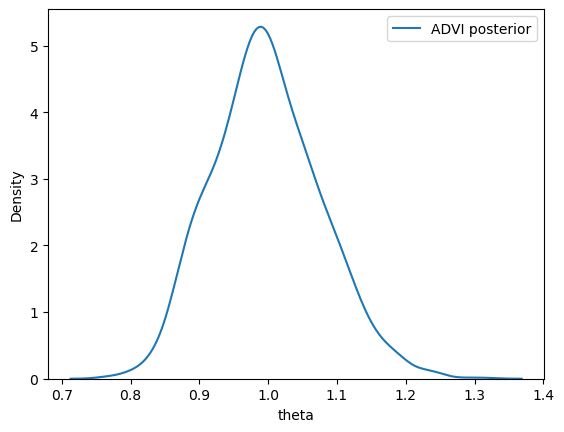

In [48]:
import warnings
warnings.filterwarnings("ignore")

# plt.plot(theta_range, exact_posterior.prob(theta_range), "b--", label="$p(x)$: True Posterior")
sns.kdeplot(sigmas, label="ADVI posterior") #, bw_adjust=1)
plt.xlabel("theta")
plt.legend()